We can build a separate sub-CNN model or head for each input variable (refer to as a **multi-headed CNN model**).  This is similar to ensemble approach.

Starting with the model, we must define a separate CNN model for each of the eight input variables. The configuration of the model, including the number of layers and their hyperparameters, were also modified to better suit the new approach. The new configuration is not optimal and was found with a little trial and error. The multi-headed model is specified using the more flexible functional API for defining Keras models.

In [1]:
from math import sqrt
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error 
import matplotlib.pyplot as plt

from keras.utils.vis_utils import plot_model
from keras.layers import Dense, Flatten, Input

from keras.layers.convolutional import Conv1D, MaxPooling1D
 
from keras.models import Model

from keras.layers.merge import concatenate

Using TensorFlow backend.
/Users/tridoan/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/tridoan/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/tridoan/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/tridoan/opt/anaconda3/lib/pytho

In [2]:

from keras.utils.vis_utils import plot_model



In [3]:
# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-328], data[-328:-6] 
    # restructure into windows of weekly data 
    train = np.array(np.split(train, len(train)/7)) 
    test = np.array(np.split(test, len(test)/7)) 
    return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted): 
    scores = list()
    # calculate an RMSE score for each day 
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = np.sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s=0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores


# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores]) 
    print('%s: [%.3f] %s' % (name, score, s_scores))
    # convert history into inputs and outputs
    
def to_supervised(train, n_input, n_out=7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2])) 
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance 
        if out_end <= len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return np.array(X), np.array(y)

# plot training history
def plot_history(history):
    # plot loss
    plt.subplot(2, 1, 1) 
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test') 
    plt.title('loss', y=0, loc='center') 
    plt.legend()
    # plot rmse
    plt.subplot(2, 1, 2) 
    plt.plot(history.history['rmse'], label='train') 
    plt.plot(history.history['val_rmse'], label='test') 
    plt.title('rmse', y=0, loc='center') 
    plt.legend()
    plt.show()
   

In [8]:
# train the model
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 25, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1] 
    # create a channel for each variable
    in_layers, out_layers = list(), list()
    for _ in range(n_features):
        inputs = Input(shape=(n_timesteps,1))
        conv1 = Conv1D(32, 3, activation='relu')(inputs) 
        conv2 = Conv1D(32, 3, activation='relu')(conv1) 
        pool1 = MaxPooling1D()(conv2)
        flat = Flatten()(pool1)
        # store layers

        in_layers.append(inputs)
        out_layers.append(flat)
        
    # merge heads
    merged = concatenate(out_layers)
      # interpretation
    dense1 = Dense(200, activation='relu')(merged) 
    dense2 = Dense(100, activation='relu')(dense1) 
    outputs = Dense(n_outputs)(dense2)
    model = Model(inputs=in_layers, outputs=outputs) 
    # compile model
    model.compile(loss='mse', optimizer='adam')
    # plot the model
    plot_model(model, show_shapes=True, to_file='./Downloads/data/multiheaded_cnn.png')
    # fit network
    input_data = [train_x[:,:,i].reshape((train_x.shape[0],n_timesteps,1)) for i in range(n_features)]
    model.fit(input_data, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose) 
    return model

# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = np.array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
      # reshape into n input arrays
    input_x = [input_x[:,i].reshape((1,input_x.shape[0],1)) for i in range(input_x.shape[1])] 
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

# evaluate a single model
def evaluate_model(train, test, n_input): 
    # fit model
    model = build_model(train, n_input)
    # history is a list of weekly data 
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
            # store the predictions
        predictions.append(yhat_sequence)
            # get real observation and add to history for predicting the next week
        history.append(test[i, :])
      # evaluate predictions days for each week
    predictions = np.array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions) 
    return score, scores

cnn: [447.795] 425.2, 482.8, 414.6, 440.9, 409.6, 343.7, 581.0


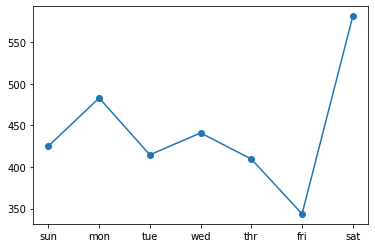

In [9]:
# load the new file
dataset = pd.read_csv('./Downloads/data/household_power_consumption_days.csv', header=0,infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 14
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('cnn', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat'] 
plt.plot(days, scores, marker='o', label='cnn')
plt.show()

We can see that in this case, the overall RMSE is skillful compared to a naive forecast, but with the chosen configuration may not perform better than the multi-channel model in the previous section.

